# CNA GHCNh Investigation

Look at trends in the Global Historical Climatology Network hourly (GHCNh) database for the Central US.

In [1]:
import sys
import os
sys.path.append('../')
from setup import CWD, SCRATCH_DIR, FIG_DIR, DATA_DIR

import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from rich import print

def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

Load data. Remember times are in Central Standard Time (CST, -6 UTC). If there are multiple hourly measurements, we take the mean. 

In [2]:
GHCNh_file = os.path.join(SCRATCH_DIR, 'GHCNh_cna.parquet')
schema = {
    'Station_ID': pl.String,
    'Station_name': pl.String,
    'time': pl.Datetime(),
    'wind_speed': pl.Float32,
    'wind_direction': pl.Float32,
    'Latitude': pl.Float32,
    'Longitude': pl.Float32,
}
df = (
    pl.scan_parquet(GHCNh_file, schema=schema)
    # Only want full years
    .filter(pl.col('time').dt.year() >= 1979)
    .filter(pl.col('time').dt.year() <= 2024)
    # Latitudes and things can be slightly off so *only* group by Station_ID
    .group_by_dynamic('time', every='1h', group_by='Station_ID').agg([
        pl.col(['Station_name', 'Latitude', 'Longitude']).first(), 
        pl.col(['wind_speed', 'wind_direction']).mean(),
    ])
    .sort('time')
)

metadata = (
    df
    .select(['Station_ID','Station_name', 'Latitude', 'Longitude'])
    # Only determine uniqueness from 'Station_ID'
    .unique(subset='Station_ID', keep='first') # setting `keep='first'` ensures reproducibility
    .collect()
)
# One station has wrong metadata, manually go in and fix
metadata = metadata.with_columns(
    # Schriever Air Force Base, CO
    Longitude=pl.when(pl.col('Longitude') == -121.1).then(-104.5).otherwise(pl.col('Longitude'))
)
# ensure that no station is duplicate
assert metadata['Station_ID'].is_duplicated().sum() == 0
metadata

Station_ID,Station_name,Latitude,Longitude
str,str,f32,f32
"""USW00000351""","""CAMERON MUNI AP""",30.878901,-96.9711
"""USW00004935""","""HOLDREGE BREWSTER FLD AP""",40.450001,-99.339203
"""USI0000KH08""","""HIGH ISLAND 264C""",28.4667,-93.733299
"""USI0000KHSD""","""SUNDANCE AIRPARK""",35.601799,-97.7062
"""USW00004913""","""CHARITON MUNI AP""",41.019402,-93.359398
…,…,…,…
"""USW00000280""","""MEADOW LAKE AP""",38.946098,-104.57
"""USW00003965""","""STILLWATER RGNL AP""",36.162498,-97.089401
"""USW00000262""","""MUSTANG IS A85A""",27.733101,-96.183098


## Plot total number of samples by year

Realistically should put this plot after I have a final dataset

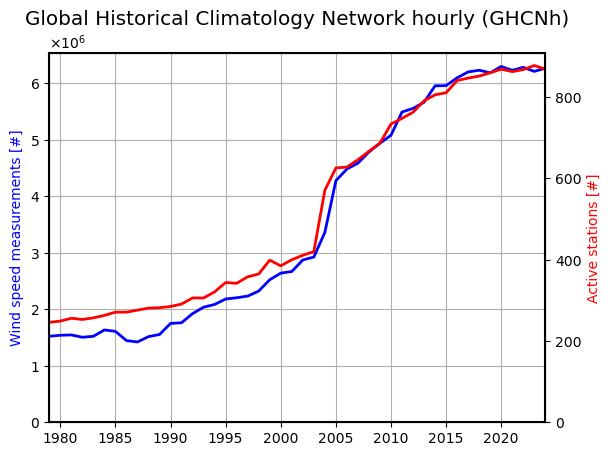

In [3]:
fig, ax = plt.subplots()
year_samples = df.group_by_dynamic('time', every='1y').agg(records=pl.col('wind_speed').len()).collect()
stations_per_year = df.group_by_dynamic('time', every='1y').agg(records=pl.col('Station_ID').unique().len()).collect()

ax.plot(year_samples['time'], year_samples['records'], color='b', lw=2)
ax.grid()
ax.set_ylim(0, None)
ax.set_xlim(year_samples['time'][0], year_samples['time'][-1])
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.set_ylabel('Wind speed measurements [#]', color='b')
ax.set_title('Global Historical Climatology Network hourly (GHCNh)', fontsize='x-large')

ax2 = ax.twinx()
ax2.plot(stations_per_year['time'], stations_per_year['records'], color='r', lw=2)
ax2.set_ylabel('Active stations [#]', color='r')
ax2.set_ylim(0, None)
for spine in ax2.spines.values():
    spine.set_linewidth(1.5)

plt.savefig(os.path.join(FIG_DIR, 'GHCNh_number_of_raw_records.png'), dpi=300)
plt.show()

## Filter dataframe to stations with a consistent record
To count as a valid day: `>= 4 measurements`

To count as a valid month: `>= 14 valid days`

To count as a valid year: `12 valid months`

In [4]:
good_years = (
    df
    .group_by_dynamic('time', every='1d', group_by='Station_ID')
    .agg(day_obs=pl.col('wind_speed').len())
    .filter(pl.col('day_obs') >= 4) # remove bad days
    # Cascade into months
    .group_by_dynamic('time', every='1mo', group_by='Station_ID')
    .agg(month_obs=pl.col('day_obs').len())
    .filter(pl.col('month_obs') >= 14) # remove bad months
    # Cascade into years
    .group_by_dynamic('time', every='1y', group_by='Station_ID')
    .agg(year_obs=pl.col('month_obs').len())
    .filter(pl.col('year_obs') == 12) # remove bad years
    .collect()
)
# Now get the number of active years
valid_stations = (
    good_years
    .group_by('Station_ID')
    .agg(num_years=pl.col('year_obs').len())
    .filter(pl.col('num_years') == 46) # 46 is 1979-2024
    .sort(pl.col('num_years'))
)
# Get the total number of records for each station
records_per = df.group_by('Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()
records_per_year = df.group_by_dynamic('time', every='1y', group_by='Station_ID').agg(num_obs=pl.col('wind_speed').len()).collect()

# Join with the station data
valid_stations = valid_stations.join(records_per, how='left', on='Station_ID')
good_years = (
    good_years
    .filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
    .join(records_per_year, how='left', on=['Station_ID', 'time'])
)

print('good_years', good_years.head()) # has yearly stats
print('valid_stations', valid_stations.head()) # has summary stats
print(f'Number of valid stations: {len(valid_stations)}')

good_years shape: (5, 4)
┌─────────────┬─────────────────────┬──────────┬─────────┐
│ Station_ID  ┆ time                ┆ year_obs ┆ num_obs │
│ ---         ┆ ---                 ┆ ---      ┆ ---     │
│ str         ┆ datetime[μs]        ┆ u32      ┆ u32     │
╞═════════════╪═════════════════════╪══════════╪═════════╡
│ CAN05010481 ┆ 1979-01-01 00:00:00 ┆ 12       ┆ 8352    │
│ CAN05010481 ┆ 1980-01-01 00:00:00 ┆ 12       ┆ 8784    │
│ CAN05010481 ┆ 1981-01-01 00:00:00 ┆ 12       ┆ 8760    │
│ CAN05010481 ┆ 1982-01-01 00:00:00 ┆ 12       ┆ 8760    │
│ CAN05010481 ┆ 1983-01-01 00:00:00 ┆ 12       ┆ 8760    │
└─────────────┴─────────────────────┴──────────┴─────────┘

valid_stations shape: (5, 3)
┌─────────────┬───────────┬─────────┐
│ Station_ID  ┆ num_years ┆ num_obs │
│ ---         ┆ ---       ┆ ---     │
│ str         ┆ u32       ┆ u32     │
╞═════════════╪═══════════╪═════════╡
│ USW00013960 ┆ 46        ┆ 350908  │
│ USW00013942 ┆ 46        ┆ 301316  │
│ CAN05010481 ┆ 46        ┆ 402598  │
│ USW00012917 ┆ 46        ┆ 360985  │
│ USW00013911 ┆ 46        ┆ 335374  │
└─────────────┴───────────┴─────────┘

Number of valid stations: 118

### Plot this

Median # of observations: 7911.0, averages out to 21.67 per day (assuming 365 days per year)

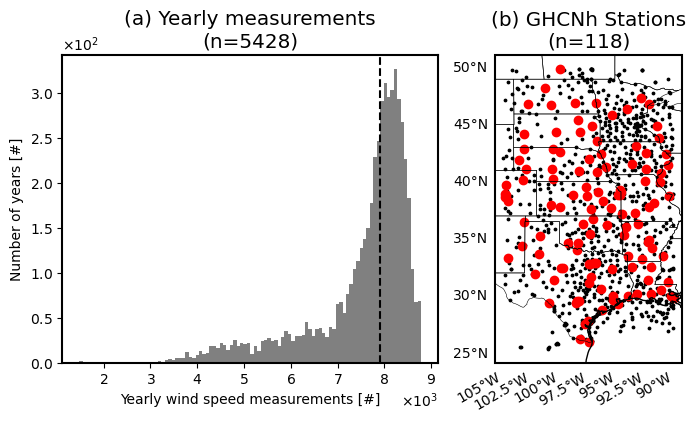

In [5]:
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(ncols=2, width_ratios=[2,1])

# Plot 1: Years of Valid Record
ax = fig.add_subplot(gs[0])
ax.hist(good_years['num_obs'], bins=100, color='gray')
# mean_obs = int(good_years['num_obs'].mean())
median = round(good_years['num_obs'].median(), 1)
print(f'Median # of observations: {median}, averages out to {round(median/365, 2)} per day (assuming 365 days per year)')
ax.axvline(median, color='k', linestyle='dashed')
# txt = f'Mean # of yearly measurements: {mean_obs}\nMean # of measurements/day: {round(mean_obs/365, 1)}'
# ax.text(0.35, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.set_xlabel('Yearly wind speed measurements [#]')
ax.set_ylabel('Number of years [#]')
ax.set_title(f'(a) Yearly measurements\n(n={len(good_years)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Plot all stations then selected stations
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.scatter(metadata['Longitude'], metadata['Latitude'], transform=ccrs.PlateCarree(), c='k', s=3)
metadata_filtered = metadata.filter(pl.col('Station_ID').is_in(valid_stations['Station_ID'].to_numpy()))
ax.scatter(metadata_filtered['Longitude'], metadata_filtered['Latitude'], transform=ccrs.PlateCarree(), c='r')
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'(b) GHCNh Stations\n(n={len(metadata_filtered)})', fontsize='x-large')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_valid_stations.png'), dpi=300)
plt.show()

## Look at mean trends

We want to quantify changes to CNA mean wind speeds. Below are some thoughts.

- Hurricane season in the Atlantic is June through the end of November
- The GPLLJ is mainly a nocturnal, summertime phenomenon
- Any diurnal cycles would relate to heating at the surface, potentially the reduction in static stability proposed by Morris et al. (2023, 24, 25)
- Zeng et al. (2019) sees "global stilling" decrease of -0.08 m/s/decade
- Pryor et a. (2007): "the relative trends are larger for 50th percentile wind speeds than the 90th percentile" -> decreases are less pronounced at high wind speeds
- Also from Pryor et al. (2007):
> Short-term reverse trends are observed in the 50th percentile wind speed at a total of 79 stations in the data set of 157 sites. Sixty-one stations that overall exhibit declining trends, also have statistically significant positive trends over a component of the time series of greater or equal to one decade in duration.

In [6]:
good_IDs = valid_stations['Station_ID'].to_numpy()

### Function to reduce data to monthly given variable numbers of daily measurements

In [7]:
def make_monthly(df, good_IDs):
    agg_spec = [
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ]
        # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Want to get monthly average on a per station basis
        .group_by_dynamic('time', every='1d', group_by='Station_ID').agg(agg_spec)
        .group_by_dynamic('time', every='1mo', group_by='Station_ID').agg(agg_spec)
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .sort('time')
    )
    return new_df

df_mo = make_monthly(df, good_IDs).collect()
df_mo

/tmp/ipykernel_4101683/1990160147.py:28: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_mo = make_monthly(df, good_IDs).collect()


Station_ID,time,wind_speed,wind_direction,season
str,datetime[μs],f32,f32,str
"""CAN05010481""",1979-01-01 00:00:00,4.040845,22.642473,"""DJF"""
"""USI0000KBRO""",1979-01-01 00:00:00,5.233332,210.263992,"""DJF"""
"""USI0000KLCH""",1979-01-01 00:00:00,5.082012,193.837997,"""DJF"""
"""USW00003904""",1979-01-01 00:00:00,5.088584,214.105469,"""DJF"""
"""USW00003919""",1979-01-01 00:00:00,5.616114,231.962662,"""DJF"""
…,…,…,…,…
"""USW00094908""",2024-12-01 00:00:00,4.82688,207.052216,"""DJF"""
"""USW00094910""",2024-12-01 00:00:00,4.667172,220.655945,"""DJF"""
"""USW00094931""",2024-12-01 00:00:00,3.731497,239.025742,"""DJF"""


We now perform a Mann-Kendall test to test for monotonic decreases to windspeed

From [PNNL](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm)

> The purpose of the Mann-Kendall (MK) test (Mann 1945, Kendall 1975, Gilbert 1987) is to statistically assess if there is a monotonic upward or downward trend of the variable of interest over time. A monotonic upward (downward) trend means that the variable consistently increases (decreases) through time, but the trend may or may not be linear. The MK test can be used in place of a parametric linear regression analysis, which can be used to test if the slope of the estimated linear regression line is different from zero. The regression analysis requires that the residuals from the fitted regression line be normally distributed; an assumption not required by the MK test, that is, the MK test is a non-parametric (distribution-free) test.


In [102]:
from sklearn.linear_model import LinearRegression
import pymannkendall as mk
yearly = df_mo.group_by_dynamic('time', every='1y').agg([
    pl.col('wind_speed').mean().alias('wind_mean'),
    (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
])
x = yearly['time'].dt.year().to_numpy()
y = yearly['wind_mean'].to_numpy()
# Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
result = mk.original_test(y, alpha=0.01)
print(result)
print(f'Decadal slope: {result.slope*10}')

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.001564945111822924),
    z=np.float64(-3.1623627045916476),
    Tau=np.float64(-0.32367149758454106),
    s=np.float64(-335.0),
    var_s=11155.0,
    slope=np.float64(-0.004336481509001359),
    intercept=np.float64(4.597227988035782)
)

Decadal slope: -0.04336481509001359

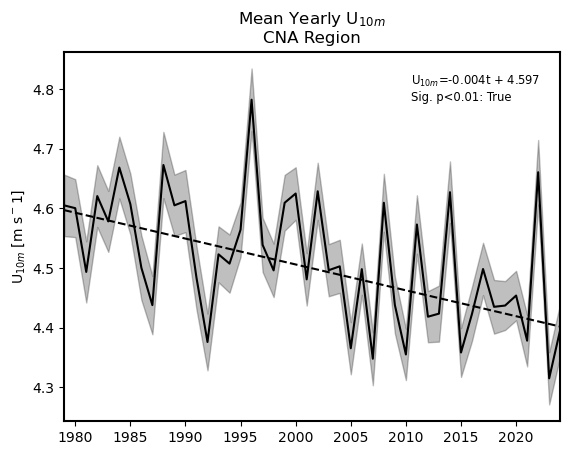

In [103]:
fig, ax = plt.subplots()
# y = y-np.mean(y[:5])
err = yearly['wind_stderr'].to_numpy()*1.96 # z-score for 95%
ax.plot(x, y, color='k')
ax.fill_between(x, y-err, y+err, color='k', alpha=0.25)
# regress
new_y = result.intercept+result.slope*(x-1979)
ax.plot(x, new_y, color='k', linestyle='dashed')
txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.01: {result.h}'
ax.text(0.7, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA Region')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m.png'), dpi=300)
plt.show()

DJF

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.066236258090552),
    z=np.float64(-1.836821451169999),
    Tau=np.float64(-0.18840579710144928),
    s=np.float64(-195.0),
    var_s=11155.0,
    slope=np.float64(-0.0042447249094645185),
    intercept=np.float64(4.703109383583069)
)

Decadal slope: -0.04244724909464519

MAM

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.15554283622459053),
    z=np.float64(-1.4202227715231952),
    Tau=np.float64(-0.14589371980676327),
    s=np.float64(-151.0),
    var_s=11155.0,
    slope=np.float64(-0.0031003952026367188),
    intercept=np.float64(5.067920923233032)
)

Decadal slope: -0.031003952026367188

JJA

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.01985030801700427),
    z=np.float64(-2.32916534529804),
    Tau=np.float64(-0.23864734299516907),
    s=np.float64(-247.0),
    var_s=11155.0,
    slope=np.float64(-0.003533970225941051),
    intercept=np.float64(4.210143631154841)
)

Decadal slope: -0.03533970225941051

SON

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(1.8722561638151447e-05),
    z=np.float64(-4.279604618189895),
    Tau=np.float64(-0.43768115942028984),
    s=np.float64(-453.0),
    var_s=11155.0,
    slope=np.float64(-0.006185448688009511),
    intercept=np.float64(4.4666252550871475)
)

Decadal slope: -0.06185448688009511

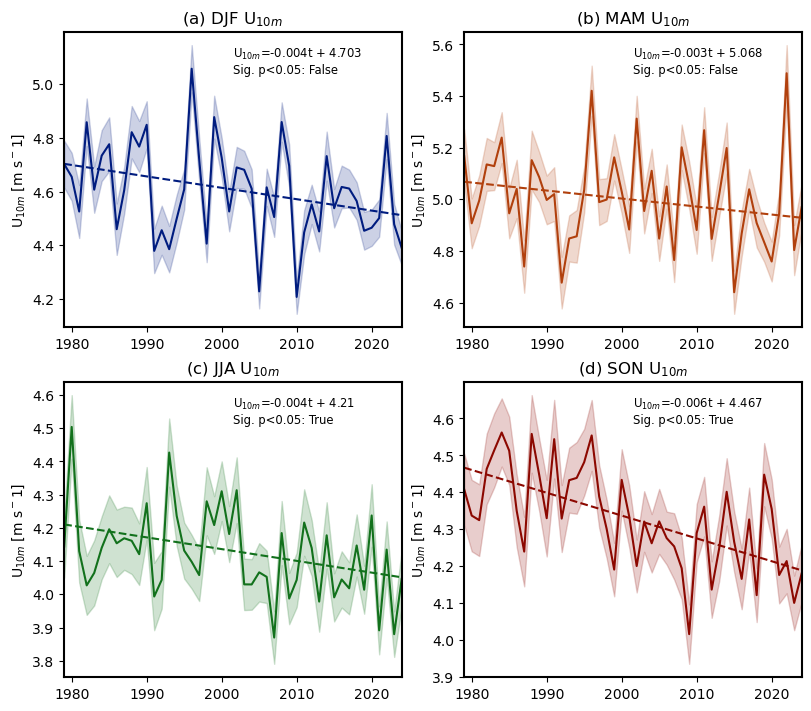

In [116]:
from string import ascii_lowercase
import seaborn as sns
import itertools

palette = itertools.cycle(sns.color_palette('dark'))

fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])
    s_yearly = (
        df_mo
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    x = s_yearly['time'].dt.year().to_numpy()
    y = s_yearly['wind_mean'].to_numpy()
    c = next(palette)
    # y = y-np.mean(y)
    err = s_yearly['wind_stderr'].to_numpy()*1.96 # z-score for 95%
    ax.plot(x, y, color=c)
    ax.fill_between(x, y-err, y+err, alpha=0.2, color=c)
    # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
    result = mk.original_test(y, alpha=0.05)
    print('\n\n'+season)
    print(result)
    print(f'Decadal slope: {result.slope*10}')
    new_y = result.intercept+result.slope*(x-1979)
    ax.plot(x, new_y, color=c, linestyle='dashed')
    txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.05: {result.h}'
    ax.text(0.5, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
    ax.set_title(f'({ascii_lowercase[i]}) {season}'+' U$_{10m}$')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_by_season.png'), dpi=300)
plt.show()

### Split into daytime and nocturnal

Day is `[06, 18)`, night is `[18, 06]` (recall this data is in CST). Filter by day because night goes till the next day so it gets tricky.

In [77]:
def make_monthly_diurnal(df, good_IDs):
    agg_spec = [
            pl.col(['wind_speed', 'wind_direction']).mean(),
        ]
        # Define a function to map month to season
    def month_to_season(month):
        if month in [12, 1, 2]:
            return "DJF"  # Winter
        elif month in [3, 4, 5]:
            return "MAM"  # Spring
        elif month in [6, 7, 8]:
            return "JJA"  # Summer
        else:
            return "SON"  # Autumn
    new_df = (
        df
        .filter(pl.col('Station_ID').is_in(good_IDs))
        # Add a column for day
        .with_columns(
            day = (pl.col('time').dt.hour() >= 6) & (pl.col('time').dt.hour() < 18)
        )
        # Want to get monthly average on a per station basis
        .group_by_dynamic('time', every='1d', group_by=['Station_ID', 'day']).agg(agg_spec)
        .group_by_dynamic('time', every='1mo', group_by=['Station_ID', 'day']).agg(agg_spec)
        .with_columns([
            pl.col('time').dt.month().map_elements(month_to_season).alias('season')
        ])
        .sort('time')
    )
    return new_df

df_mod = make_monthly_diurnal(df, good_IDs).collect()
df_mod

/tmp/ipykernel_4101683/3086720060.py:32: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  df_mod = make_monthly_diurnal(df, good_IDs).collect()


Station_ID,day,time,wind_speed,wind_direction,season
str,bool,datetime[μs],f32,f32,str
"""CAN05010481""",false,1979-01-01 00:00:00,4.001643,23.11828,"""DJF"""
"""CAN05010481""",true,1979-01-01 00:00:00,4.080048,22.166666,"""DJF"""
"""USI0000KBRO""",false,1979-01-01 00:00:00,4.796292,199.97702,"""DJF"""
"""USI0000KBRO""",true,1979-01-01 00:00:00,5.644269,219.587738,"""DJF"""
"""USI0000KLCH""",false,1979-01-01 00:00:00,4.910814,190.338715,"""DJF"""
…,…,…,…,…,…
"""USW00094931""",true,2024-12-01 00:00:00,3.858337,237.440338,"""DJF"""
"""USW00094938""",false,2024-12-01 00:00:00,3.839559,235.223938,"""DJF"""
"""USW00094938""",true,2024-12-01 00:00:00,3.972662,221.36998,"""DJF"""


day

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.21837532925140546),
    z=np.float64(-1.2308597353201025),
    Tau=np.float64(-0.12657004830917876),
    s=np.float64(-131.0),
    var_s=11155.0,
    slope=np.float64(-0.0013439995901925223),
    intercept=np.float64(4.940817764827183)
)

Decadal slope: -0.013439995901925222

night

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(4.194152906755733e-06),
    z=np.float64(-4.601521779735152),
    Tau=np.float64(-0.47053140096618357),
    s=np.float64(-487.0),
    var_s=11155.0,
    slope=np.float64(-0.006250775378683339),
    intercept=np.float64(4.1735604223997695)
)

Decadal slope: -0.06250775378683339

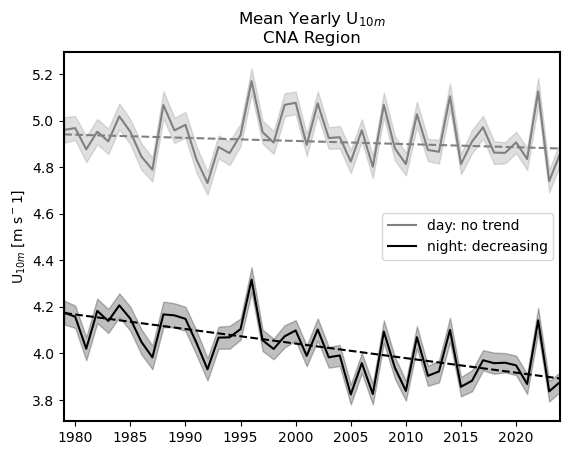

In [112]:
yearly = df_mod.group_by_dynamic('time', every='1y', group_by='day').agg([
    pl.col('wind_speed').mean().alias('wind_mean'),
    (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
])
x = yearly['time'].unique().dt.year().to_numpy()
fig, ax = plt.subplots()
for time in ['day', 'night']:
    if time == 'day':
        c = 'gray'
        y = yearly.filter(pl.col('day') == True)['wind_mean'].to_numpy()
        err = yearly.filter(pl.col('day') == True)['wind_stderr'].to_numpy()*1.96 # z-score for 95%
    else:
        c = 'black'
        y = yearly.filter(pl.col('day') == False)['wind_mean'].to_numpy()
        err = yearly.filter(pl.col('day') == False)['wind_stderr'].to_numpy()*1.96 # z-score 95%
    # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
    print(time)
    result = mk.original_test(y, alpha=0.01)
    print(result)
    print(f'Decadal slope: {result.slope*10}')
    new_y = result.intercept+result.slope*(x-1979)
    ax.plot(x, new_y, color=c, linestyle='dashed')
    txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.01: {result.h}'
    ax.plot(x, y, color=c, label=time+': '+result.trend)
    ax.fill_between(x, y-err, y+err, color=c, alpha=0.25)
    #ax.text(0.7, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
ax.set_xlim(x[0], x[-1])
ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
ax.set_title('Mean Yearly U$_{10m}$\nCNA Region')
ax.legend()
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_diurnal.png'), dpi=300)
plt.show()

### Now look at diurnal trends for each season

DJFday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.2255416917319515),
    z=np.float64(-1.211923431699793),
    Tau=np.float64(-0.1246376811594203),
    s=np.float64(-129.0),
    var_s=11155.0,
    slope=np.float64(-0.0024510622024536133),
    intercept=np.float64(4.976050913333893)
)

Decadal slope: -0.024510622024536133

DJFnight

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.051123784784707915),
    z=np.float64(-1.9504392728918547),
    Tau=np.float64(-0.2),
    s=np.float64(-207.0),
    var_s=11155.0,
    slope=np.float64(-0.003929429584079319),
    intercept=np.float64(4.2889708280563354)
)

Decadal slope: -0.039294295840793185

MAMday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.42642461891641004),
    z=np.float64(0.7953247520529892),
    Tau=np.float64(0.0821256038647343),
    s=np.float64(85.0),
    var_s=11155.0,
    slope=np.float64(0.0020086581890399638),
    intercept=np.float64(5.442930753414448)
)

Decadal slope: 0.02008658189039964

MAMnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.00802342387614563),
    z=np.float64(-2.6510825068432977),
    Tau=np.float64(-0.2714975845410628),
    s=np.float64(-281.0),
    var_s=11155.0,
    slope=np.float64(-0.006176695227622986),
    intercept=np.float64(4.544514916837215)
)

Decadal slope: -0.06176695227622986

JJAday

Mann_Kendall_Test(
    trend='no trend',
    h=np.False_,
    p=np.float64(0.7909260715569881),
    z=np.float64(0.26510825068432975),
    Tau=np.float64(0.028019323671497585),
    s=np.float64(29.0),
    var_s=11155.0,
    slope=np.float64(0.0002868864271375868),
    intercept=np.float64(4.47815465927124)
)

Decadal slope: 0.0028688642713758676

JJAnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(9.375574921755003e-06),
    z=np.float64(-4.431095047152369),
    Tau=np.float64(-0.45314009661835747),
    s=np.float64(-469.0),
    var_s=11155.0,
    slope=np.float64(-0.006691435972849528),
    intercept=np.float64(3.793131023645401)
)

Decadal slope: -0.06691435972849528

SONday

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(0.003998017092012418),
    z=np.float64(-2.8783181502870088),
    Tau=np.float64(-0.2946859903381642),
    s=np.float64(-305.0),
    var_s=11155.0,
    slope=np.float64(-0.004221765618575246),
    intercept=np.float64(4.847182938927098)
)

Decadal slope: -0.04221765618575246

SONnight

Mann_Kendall_Test(
    trend='decreasing',
    h=np.True_,
    p=np.float64(2.038165218287702e-05),
    z=np.float64(-4.260668314569585),
    Tau=np.float64(-0.4357487922705314),
    s=np.float64(-451.0),
    var_s=11155.0,
    slope=np.float64(-0.006917592250939571),
    intercept=np.float64(3.9756772301413794)
)

Decadal slope: -0.06917592250939572

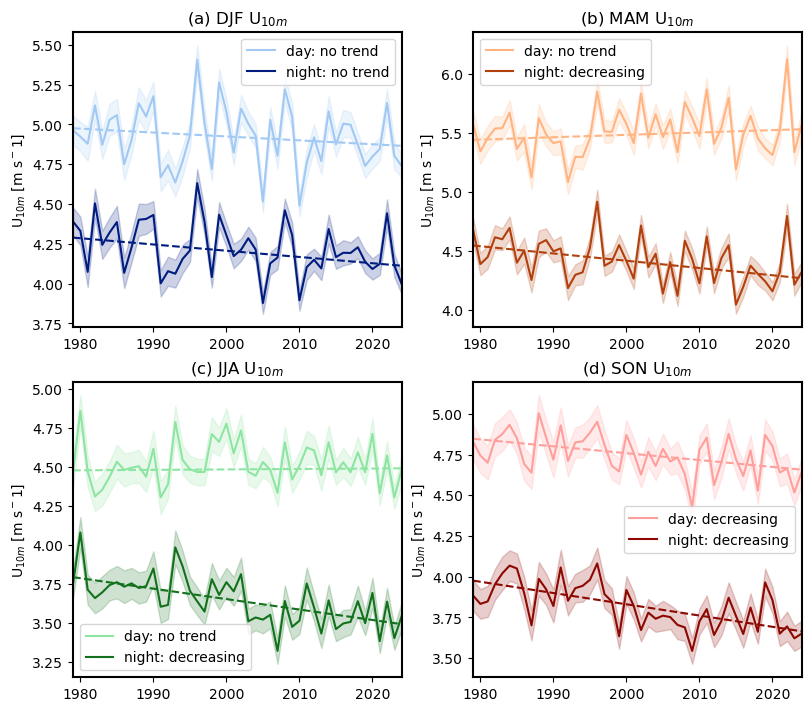

In [115]:
day_palette = itertools.cycle(sns.color_palette('pastel'))
night_palette = itertools.cycle(sns.color_palette('dark'))

fig = plt.figure(figsize=(8,7), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=2)
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = fig.add_subplot(gs[i])
    s_yearly = (
        df_mod
        .filter(pl.col('season') == season)
        .group_by_dynamic('time', every='1y', group_by='day').agg([
            pl.col('wind_speed').mean().alias('wind_mean'),
            (pl.col('wind_speed').std()/np.sqrt(pl.col('wind_speed').len())).alias('wind_stderr')
        ])
    )
    x = s_yearly['time'].unique().dt.year().to_numpy()
    for time in ['day', 'night']:
        if time == 'day':
            c = next(day_palette)
            y = s_yearly.filter(pl.col('day') == True)['wind_mean'].to_numpy()
            err = s_yearly.filter(pl.col('day') == True)['wind_stderr'].to_numpy()*1.96 # z-score for 95%
        else:
            c = next(night_palette)
            y = s_yearly.filter(pl.col('day') == False)['wind_mean'].to_numpy()
            err = s_yearly.filter(pl.col('day') == False)['wind_stderr'].to_numpy()*1.96 # z-score 95%
        # Perform a Mann-Kendall test to see if there is a monotonic decreasing or increasing trend
        result = mk.original_test(y, alpha=0.05)
        print('\n\n'+season+time)
        print(result)
        print(f'Decadal slope: {result.slope*10}')
        new_y = result.intercept+result.slope*(x-1979)
        ax.plot(x, new_y, color=c, linestyle='dashed')

        ax.plot(x, y, color=c, label=time+': '+result.trend)
        ax.fill_between(x, y-err, y+err, alpha=0.2, color=c)
        ax.legend()
    # txt='U$_{10m}$='+str(round(result.slope, 3))+'t + '+str(round(result.intercept, 3))+f'\nSig. p<0.05: {result.h}'
    # ax.text(0.5, 0.9, txt, fontsize='small', horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('U$_{10m}$ [m s$^-1$]')
    ax.set_title(f'({ascii_lowercase[i]}) {season}'+' U$_{10m}$')
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
plt.savefig(os.path.join(FIG_DIR, 'GHCNh_cna_yearly_U10m_by_season_diurnal.png'), dpi=300)
plt.show()